In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd ~/.kaggle

[Errno 2] No such file or directory: '/root/.kaggle'
/content


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
ls -al

total 24
drwxr-xr-x 1 root root 4096 Jun 11 02:08 ./
drwxr-xr-x 1 root root 4096 Jun 11 02:07 ../
drwxr-xr-x 4 root root 4096 Jun  7 13:33 .config/
drwx------ 5 root root 4096 Jun 11 02:08 gdrive/
-rw-r--r-- 1 root root   68 Jun 11 02:08 kaggle.json
drwxr-xr-x 1 root root 4096 Jun  7 13:39 sample_data/


In [6]:
cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [7]:
ls -al

total 13648
-rw------- 1 root root     5568 Mar 19 06:56  assignment_week3.ipynb
-rw------- 1 root root 10713856 Jun 10 17:03  best_model.h5
-rw------- 1 root root    42954 May 28 05:15  chap8.ipynb
-rw------- 1 root root   128771 Oct 22  2023 'Colaboratory에 오신 것을 환영합니다의 사본'
-rw------- 1 root root   128771 Oct 22  2023 'Colaboratory에 오신 것을 환영합니다의 사본 (1)'
drwx------ 2 root root     4096 Apr  2 05:13  covid19/
drwx------ 2 root root     4096 May 28 02:49  ecg/
-rw------- 1 root root    14007 Jun 11 02:08  finalProject.ipynb
drwx------ 2 root root     4096 Apr  2 04:49  .ipynb_checkpoints/
-rw------- 1 root root       68 Jun  4 05:35  kaggle.json
drwx------ 2 root root     4096 May 28 05:11  pknu-deep-learning-2024/
drwx------ 2 root root     4096 May 24 10:01  svc2004/
-rw------- 1 root root     5413 Jun 10 19:00  test_predict.csv
drwx------ 2 root root     4096 Apr  2 04:49  titanic/
-rw------- 1 root root      734 Apr  2 05:17  Untitled0.ipynb
-r

In [8]:
ls '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata/Train' | wc -l

800


In [9]:
folderpath = '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata'

In [10]:
import random
import tensorflow as tf
seed_num = 71
random.seed(seed_num)

In [11]:
import numpy as np
import os


# 파라미터로 학습 및 테스트 폴더의 모든 서명 데이터를 읽고
#전체 서명의 길이 중 가장 긴 길이의 값을 반환
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d,tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

# 파라미터로 주어진 폴더에 들어 있는 서명 파일 전체를 읽고,
#n_files * n_max_len * 2 크기의 numpy 배열로 만들어 반환
# 파라미터 n_max_len은 전체 서명 데이터들 중 가장 긴 서며야의 길이를 의미

# 데이터와 함께 반환하는 len_sign 는 각 서명의 실제 길이를 의미

def load_data(folderpath, n_max_len, sig_ids):
  filelist = os.listdir(folderpath)
  n_files = len(filelist)
  d = np.zeros((n_files, n_max_len,2))

  len_sign = np.zeros(n_files)

  for i in sig_ids:
    filepath = f'{folderpath}/{i}.TXT'
    d_tmp, len_sign[i-sig_ids[0]] = load_a_sig(filepath)

    d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp
  return d,len_sign


# 파라미터로 주어진 서명 파일을 읽고, nPoint * 2 크기의 numpy 배열로 만들어 반환

def load_a_sig(filepath):
  f = open(filepath,'rt')
  nPoints = int(f.readline())

  d = np.zeros((nPoints,2))
  for i in range(nPoints):
    line = f.readline()
    toks = line.split(' ')
    d[i,:] = [int(toks[0]), int(toks[1])]
  f.close()
  return d, nPoints

In [12]:
n_train = 800
n_test = 800

n_max_len = get_max_len(f'{folderpath}/Train', f'{folderpath}/Test')

x_train, x_train_len = load_data(f'{folderpath}/Train', n_max_len,range(n_train))

x_test, x_test_len = load_data(f'{folderpath}/Test', n_max_len, range(n_train,1600))

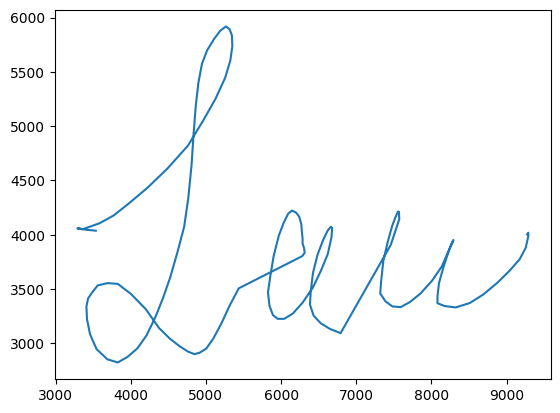

In [13]:
import matplotlib.pyplot as plt
s_id = 10
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0], x_train[s_id, :len_sig,1])

In [14]:
for i in range(x_train.shape[0]):
  len_tmp = int(x_train_len[i])
  h_min = np.min(x_train[i,:len_tmp,0])
  h_max = np.max(x_train[i,:len_tmp,0])
  v_min = np.min(x_train[i,:len_tmp,1])
  v_max = np.max(x_train[i,:len_tmp,1])
  w_h_ratio = (v_max - v_min) / (h_max - h_min)
  x_train[i,:len_tmp,0] = (x_train[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_train[i,:len_tmp,1] = (x_train[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

for i in range(x_test.shape[0]):
  len_tmp = int(x_test_len[i])
  h_min = np.min(x_test[i,:len_tmp,0])
  h_max = np.max(x_test[i,:len_tmp,0])
  v_min = np.min(x_test[i,:len_tmp,1])
  v_max = np.max(x_test[i,:len_tmp,1])

  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  x_test[i,:len_tmp,0] = (x_test[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_test[i,:len_tmp,1] = (x_test[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio


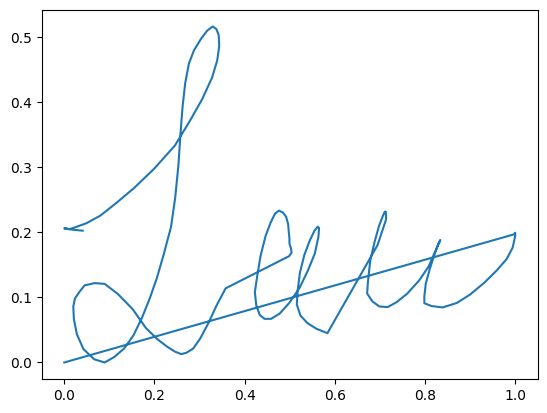

In [15]:
import matplotlib.pyplot as plt
s_id = 10
plt.plot(x_train[s_id,:,0],x_train[s_id,:,1])

In [16]:
import pandas as pd
from tensorflow import keras

y_pd = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/train_info.csv')
y_all = np.array(y_pd['bGenuine'])
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
# y_test = y_all[:n_train]


In [ ]:
from keras.layers import *
from keras.models import Model
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import random
import tensorflow as tf

seed_num = 71
random.seed(seed_num)

tf.random.set_seed(seed_num)

# def residual_block(x, filters, kernel_size=3, padding='same', activation='relu'):
#     res = Conv1D(filters, kernel_size=kernel_size, padding=padding)(x)
#     res = BatchNormalization()(res)
#     res = Activation(activation)(res)

#     res = Conv1D(filters, kernel_size=kernel_size, padding=padding)(res)
#     res = BatchNormalization()(res)

#     shortcut = Conv1D(filters, kernel_size=1, padding=padding)(x)
#     shortcut = BatchNormalization()(shortcut)

#     output = Add()([res, shortcut])
#     output = Activation(activation)(output)
#     return output

# input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

# # Gaussian noise layer
# x = GaussianNoise(0.1)(input_layer)

# # Residual blocks with increasing filters
# x = residual_block(x, 16)
# x = MaxPooling1D(pool_size=2)(x)
# x = residual_block(x, 32)
# x = MaxPooling1D(pool_size=2)(x)
# x = residual_block(x, 64)
# x = MaxPooling1D(pool_size=2)(x)
# x = residual_block(x, 128)
# x = MaxPooling1D(pool_size=2)(x)

# # Bi-directional LSTM layers
# x = Bidirectional(LSTM(128, return_sequences=True))(x)
# x = Bidirectional(LSTM(128))(x)

# # Fully connected layers with Dropout
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)  # Increased number of units
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# output_layer = Dense(2, activation='softmax')(x)

# # Create model
# model = Model(inputs=input_layer, outputs=output_layer)

# # Compile model with a learning rate scheduler
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# optimizer = Adam(learning_rate=lr_schedule)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Callbacks for early stopping and model checkpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# # Train model
# hist = model.fit(
#     x=x_train, y=y_train_cat,
#     epochs=100,
#     validation_split=0.3,
#     batch_size=64,  # Increased batch size
#     callbacks=[early_stopping, model_checkpoint]
# )

# # Load the best model
# model.load_weights('best_model.h5')

# # Evaluate model
# # score = model.evaluate(x_test, y_test_cat)
# # print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


model = Sequential()
model.add(Conv1D(16, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(16, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=9, strides=2))

model.add(Conv1D(32, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=9, strides=2))

model.add(Conv1D(64, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=9, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=9, strides=2))

model.add(Bidirectional(LSTM(128)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)  # 학습률을 낮춤
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


hist = model.fit(x=x_train, y=y_train_cat, epochs=300, validation_split=0.3, batch_size=32)




Epoch 1/300
18/18 [==============================] - 19s 462ms/step - loss: 0.6799 - accuracy: 0.5804 - val_loss: 0.6933 - val_accuracy: 0.4958
Epoch 2/300
18/18 [==============================] - 11s 645ms/step - loss: 0.6343 - accuracy: 0.6804 - val_loss: 0.6928 - val_accuracy: 0.5167
Epoch 3/300
18/18 [==============================] - 8s 472ms/step - loss: 0.5533 - accuracy: 0.7393 - val_loss: 0.7112 - val_accuracy: 0.4958
Epoch 4/300
18/18 [==============================] - 9s 487ms/step - loss: 0.4774 - accuracy: 0.7696 - val_loss: 0.7145 - val_accuracy: 0.4958
Epoch 5/300
18/18 [==============================] - 10s 580ms/step - loss: 0.4031 - accuracy: 0.8107 - val_loss: 0.7463 - val_accuracy: 0.4958
Epoch 6/300
18/18 [==============================] - 8s 434ms/step - loss: 0.3909 - accuracy: 0.8286 - val_loss: 0.8805 - val_accuracy: 0.4958
Epoch 7/300
18/18 [==============================] - 10s 542ms/step - loss: 0.3735 - accuracy: 0.8375 - val_loss: 1.1613 - val_accuracy: 0.

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def drawHistory(hist) :

  # hist.history를 데이터프레임으로 변환
  history_df = pd.DataFrame(hist.history)

  # 데이터프레임을 표로 출력
  print(history_df)

  # 데이터프레임을 시각화 (옵션)
  plt.figure(figsize=(12, 6))

  # 훈련 손실과 검증 손실 그래프
  plt.subplot(1, 2, 1)
  plt.plot(history_df['loss'], label='Training Loss')
  plt.plot(history_df['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # 훈련 정확도와 검증 정확도 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history_df['accuracy'], label='Training Accuracy')
  plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plt.show()



In [ ]:
drawHistory(hist)

In [ ]:
o = model.predict(x_test)

In [ ]:
o = np.argmax(o,1)

In [ ]:
df = pd.DataFrame(o)
df.columns = ['bGenuine']
df.index = range(800, 800+len(df))
df.index.name = 'num'
print(df)
df.to_csv('test_predict.csv')

In [ ]:
!kaggle competitions submit -c pknu-deep-learning-2024 -f test_predict.csv -m "Message"

In [ ]:
cp finalProject.ipynb /content/gdrive/MyDrive/colab_repo_for_deep_learning/finalProject.ipynb

In [ ]:
cd ../colab_repo_for_deep_learning/

In [ ]:
!git add *

In [ ]:
!git commit -m "commit"

In [ ]:
!git config --global user.email "wkdghdwns199@naver.com"

In [ ]:
!git config --global user.name "Jang Hong Joon"

In [ ]:
!git push origin main